# Desicion Tree with K-fold cross validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from dtreeviz.trees import dtreeviz
from IPython.display import Image, display_svg, SVG

Defining functions that are used within the notebook.

In [2]:
# Feature importance and selection
def plot_feature_importance(df_train, df_test, max_tree_depth, title='Feature importance'):
    clf = DecisionTreeClassifier(max_depth=max_tree_depth)
    X = df_train
    y = df_test
    clf = clf.fit(X, y)

    feature_names = df_train.columns
    feature_importance_df = pd.DataFrame(list(zip(clf.feature_importances_, feature_names)), columns=["feature_importance", "feature_name"])
    feature_importance_df = feature_importance_df.sort_values(by='feature_importance', ascending=False)
    useless_features = list(feature_importance_df[feature_importance_df['feature_importance'] == 0]['feature_name'])
    feature_importance_df = feature_importance_df[feature_importance_df['feature_importance'] != 0]

    fig = px.bar(feature_importance_df, x="feature_name", y="feature_importance", log_y=True, title=title)
    fig.show(width=900, height=500)
    

    print("The following features were dropped:")
    print(useless_features)
    return useless_features

# Plot Decision Tree
def plot_tree(model, df, label, feature_names, class_names):
   viz = dtreeviz(tree_model= model, x_data=df, y_data=label, target_name="target", feature_names=feature_names, class_names=class_names, orientation='LR')
   viz
   viz.view()

# K-fold cross validation
def cross_validation(model, _X, _Y, _cv):
      '''Function to perform 10 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=10
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_Y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data, cv):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold", "6th Fold", "7th Fold", "8th Fold", "9th Fold", "10th Fold"]
        fold_labels = labels[0:cv]
        #X_axis = np.arange(len(labels[0:cv-1]))
        X_axis = np.arange(len(labels[0:cv]))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, fold_labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

# putting it all together
def fold_classify_and_plot1(df_train, df_test, max_tree_depth, cv, criterion,title='Feature importance'):
    clf = DecisionTreeClassifier(max_depth=max_tree_depth, criterion= criterion)
    X = df_train
    y = df_test
    clf = clf.fit(X, y)
    classificationResults = cross_validation(model= clf, _X= X, _Y= y, _cv= cv)
    print(classificationResults)

    feature_names = df_train.columns
    feature_importance_df = pd.DataFrame(list(zip(clf.feature_importances_, feature_names)), columns=["feature_importance", "feature_name"])
    feature_importance_df = feature_importance_df.sort_values(by='feature_importance', ascending=False)
    useless_features = list(feature_importance_df[feature_importance_df['feature_importance'] == 0]['feature_name'])
    feature_importance_df = feature_importance_df[feature_importance_df['feature_importance'] != 0]

    fig = px.bar(feature_importance_df, x="feature_name", y="feature_importance", log_y=True, title=title)
    fig.show(width=900, height=500)
    


    print("The following features were dropped:")
    print(useless_features)

    plot_result(cv= cv, x_label= "Decision Tree", y_label= "Accuracy", plot_title= f"Accuracy scores in {cv} Folds", train_data= classificationResults["Training Accuracy scores"], val_data= classificationResults["Validation Accuracy scores"])
    plot_result(cv= cv, x_label= "Decision Tree", y_label= "Precision", plot_title= f"Precision scores in {cv} Folds", train_data= classificationResults["Training Precision scores"], val_data= classificationResults["Validation Precision scores"])
    plot_result(cv= cv, x_label= "Decision Tree", y_label= "Recall", plot_title= f"Recall scores in {cv} Folds", train_data= classificationResults["Training Recall scores"], val_data= classificationResults["Validation Recall scores"])
    plot_result(cv= cv, x_label= "Decision Tree", y_label= "F1", plot_title= f"F1 scores in {cv} Folds", train_data= classificationResults["Training F1 scores"], val_data= classificationResults["Validation F1 scores"])
    # Visualize Desicion tree
    plot_tree(clf, X, y, feature_names, class_names)

def fold_classify_and_plot2(df_train, df_test, max_tree_depth, cv, criterion, title='Feature importance'):
    clfModel = DecisionTreeClassifier(max_depth=max_tree_depth, criterion= criterion)
    X = df_train
    y = df_test
    clf = clfModel.fit(X, y)
    classificationResults = cross_validation(model= clfModel, _X= X, _Y= y, _cv= cv)
    print(classificationResults)

    feature_names = df_train.columns
    feature_importance_df = pd.DataFrame(list(zip(clfModel.feature_importances_, feature_names)), columns=["feature_importance", "feature_name"])
    feature_importance_df = feature_importance_df.sort_values(by='feature_importance', ascending=False)
    useless_features = list(feature_importance_df[feature_importance_df['feature_importance'] == 0]['feature_name'])
    feature_importance_df = feature_importance_df[feature_importance_df['feature_importance'] != 0]

    fig = px.bar(feature_importance_df, x="feature_name", y="feature_importance", log_y=True, title=title)
    fig.show(width=900, height=500)
    


    print("The following features were dropped:")
    print(useless_features)

    plot_result(cv= cv, x_label= "Decision Tree", y_label= "Accuracy", plot_title= f"Accuracy scores in {cv} Folds", train_data= classificationResults["Training Accuracy scores"], val_data= classificationResults["Validation Accuracy scores"])
    plot_result(cv= cv, x_label= "Decision Tree", y_label= "Precision", plot_title= f"Precision scores in {cv} Folds", train_data= classificationResults["Training Precision scores"], val_data= classificationResults["Validation Precision scores"])
    plot_result(cv= cv, x_label= "Decision Tree", y_label= "Recall", plot_title= f"Recall scores in {cv} Folds", train_data= classificationResults["Training Recall scores"], val_data= classificationResults["Validation Recall scores"])
    plot_result(cv= cv, x_label= "Decision Tree", y_label= "F1", plot_title= f"F1 scores in {cv} Folds", train_data= classificationResults["Training F1 scores"], val_data= classificationResults["Validation F1 scores"])


### Data Pre-processing

First we load our dataset, change the categorical "lang" column to numbers, then take a look at our columns.

In [3]:
df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")

In [4]:
var = sorted(df['lang'].unique())
var

['Select Language...',
 'ar',
 'da',
 'de',
 'el',
 'en',
 'en-AU',
 'en-GB',
 'es',
 'fil-PH',
 'fr',
 'id',
 'it',
 'ja',
 'ko',
 'nl',
 'pl',
 'pt',
 'ru',
 'sv',
 'tr',
 'xx-lc',
 'zh-CN',
 'zh-TW']

In [5]:
mapping = dict(zip(var, range(0, len(var) + 1)))
df['lang_num'] = df['lang'].map(mapping).astype(int)
df.drop(columns='lang', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   user_id                                   11109 non-null  int64  
 1   name                                      11108 non-null  object 
 2   bot                                       11109 non-null  int64  
 3   created_at                                11109 non-null  object 
 4   statuses_count                            11109 non-null  int64  
 5   account_age_in_days                       11109 non-null  int64  
 6   number_of_tweets                          11109 non-null  int64  
 7   account_average_tweets_per_day            11109 non-null  float64
 8   avg_tweets_per_actual_day                 11109 non-null  float64
 9   day_with_most_tweets                      11109 non-null  object 
 10  max_number_of_tweets_in_a_day     

Dropping non-numerical and non-categorical columns from our dataset, as they are of less interest too us when using the Desicion Tree classification model.

In [6]:
columns_to_drop = ["user_id", "name", "created_at", "day_with_most_tweets"]
df.drop(columns=columns_to_drop, inplace=True)
label = df.pop("bot")
label.value_counts()

1    6116
0    4993
Name: bot, dtype: int64

Lets take a look at our values.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
statuses_count,11109.0,486.128364,1.240441e+03,0.000000e+00,4.100000e+01,6.800000e+01,81.000000,7.226000e+03
account_age_in_days,11109.0,1827.599874,5.550895e+02,8.910000e+02,1.312000e+03,1.702000e+03,2080.000000,3.901000e+03
number_of_tweets,11109.0,941.636241,1.199367e+03,1.000000e+00,6.700000e+01,1.320000e+02,1703.000000,3.668000e+03
account_average_tweets_per_day,11109.0,0.262958,6.808833e-01,0.000000e+00,2.247191e-02,3.508772e-02,0.058267,6.792821e+00
avg_tweets_per_actual_day,11109.0,13.376648,3.797705e+01,1.000000e+00,1.846154e+00,4.777778e+00,8.058511,1.759500e+03
max_number_of_tweets_in_a_day,11109.0,52.172383,8.794356e+01,1.000000e+00,6.000000e+00,1.800000e+01,75.000000,2.131000e+03
entropy_for_day,11109.0,2.795355,1.460038e+00,0.000000e+00,1.426345e+00,2.921107e+00,3.710199,5.706424e+00
entropy_for_hour,11109.0,1.995941,1.086827e+00,0.000000e+00,1.032784e+00,2.234517e+00,2.789275,5.705947e+00
entropy_for_minute,11109.0,1.017305,6.785934e-01,0.000000e+00,4.854608e-01,7.215676e-01,1.856961,4.017732e+00
avg_hashtags,11109.0,0.156578,2.333411e-01,0.000000e+00,5.000000e-02,8.571429e-02,0.173913,6.441050e+00


Seeing as some of our values differ by many orders of magnitude, we must standardize our data. Choosing the standardscaler for this job, and only scaling non-categorical data.

In [8]:
categoric_col_names = df.columns.values.tolist()
del categoric_col_names[:-1]
numeric_col_names = df.columns.values.tolist()
del numeric_col_names[-1]

In [9]:
standard_scaler = StandardScaler().fit(df[numeric_col_names])

df[numeric_col_names] = standard_scaler.transform(df[numeric_col_names])

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
statuses_count,11109.0,-1.343181e-17,1.000045,-0.391917,-0.358863,-0.337096,-0.326615,5.433691
account_age_in_days,11109.0,-9.434247e-17,1.000045,-1.687371,-0.928901,-0.226280,0.454722,3.735422
number_of_tweets,11109.0,-2.750323e-17,1.000045,-0.784313,-0.729281,-0.675083,0.634833,2.273271
account_average_tweets_per_day,11109.0,6.396100e-18,1.000045,-0.386219,-0.353213,-0.334684,-0.300639,9.590714
avg_tweets_per_actual_day,11109.0,6.875807e-18,1.000045,-0.325913,-0.303631,-0.226433,-0.140042,45.980453
max_number_of_tweets_in_a_day,11109.0,-7.675320e-18,1.000045,-0.581904,-0.525047,-0.388589,0.259583,23.639265
entropy_for_day,11109.0,8.826618e-17,1.000045,-1.914663,-0.937696,0.086134,0.626618,1.993922
entropy_for_hour,11109.0,-1.624609e-16,1.000045,-1.836567,-0.886250,0.219526,0.729987,3.413765
entropy_for_minute,11109.0,-7.291554e-17,1.000045,-1.499206,-0.783781,-0.435830,1.237403,4.421738
avg_hashtags,11109.0,-2.686362e-17,1.000045,-0.671058,-0.456769,-0.303706,0.074293,26.933767


### Feature Selection / Dimensionality reduction

Now that our data is standardized, we can take a look at what features provide the most information to our desicionmaking process.

In [11]:
useless_features = plot_feature_importance(df, label, max_tree_depth=10)

The following features were dropped:
['mean_inactive_period_length_in_seconds']


In [12]:
useless_features = plot_feature_importance(df, label, max_tree_depth=5)

The following features were dropped:
['total_replies', 'total_likes', 'account_discussion_creation_ratio', 'entropy_for_minute', 'entropy_for_day', 'max_number_of_tweets_in_a_day', 'avg_tweets_per_actual_day', 'mean_inactive_period_length_in_seconds', 'mode_inactive_period_length_in_seconds', 'mode_count', 'statuses_count']


With a shallower desicion tree, we can see that more features will be dropped.

In [13]:
clf = DecisionTreeClassifier(max_depth=5)
X = df
y = label
clf = clf.fit(X, y)

feature_names = X.columns.tolist()
class_names = ["human", "bot"]
plot_tree(clf, X, y, feature_names, class_names)

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [20]:
import pickle
clf = DecisionTreeClassifier(max_depth=10)
X = df
y = label
clf = clf.fit(X, y)
tree_object = clf
filehandler = open("Dtree_10_depth_object", 'wb')
pickle.dump(tree_object, filehandler)

feature_names = X.columns.tolist()
class_names = ["human", "bot"]
plot_tree(clf, X, y, feature_names, class_names)

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



## Applying the Decision tree classification method and the K-fold cross validation

We split the dataset into K-folds. Starting with a typical K of 10.

{'Training Accuracy scores': array([0.86257251, 0.86007201, 0.86377275, 0.86317263, 0.85927185,
       0.86687337, 0.86557311, 0.86277255, 0.86567313, 0.86428643]), 'Mean Training Accuracy': 86.34040379433024, 'Training Precision scores': array([0.80412371, 0.80179385, 0.80572778, 0.80393886, 0.7995321 ,
       0.80906532, 0.80936803, 0.80537905, 0.81378166, 0.80725926]), 'Mean Training Precision': 0.8059969625391998, 'Training Recall scores': array([0.99200581, 0.99073401, 0.99164244, 0.99382267, 0.9934593 ,
       0.99236919, 0.98873751, 0.99000908, 0.98038147, 0.98982743]), 'Mean Training Recall': 0.99029889252371, 'Training F1 scores': array([0.88823816, 0.88630638, 0.88906988, 0.88885278, 0.88600826,
       0.89139127, 0.8901063 , 0.88820078, 0.88934663, 0.88926969]), 'Mean Training F1 Score': 0.8886790127034947, 'Validation Accuracy scores': array([0.83438344, 0.83258326, 0.85058506, 0.83438344, 0.84788479,
       0.81278128, 0.83978398, 0.84158416, 0.83528353, 0.83603604]), 'Mea

The following features were dropped:
['mean_inactive_period_length_in_seconds']


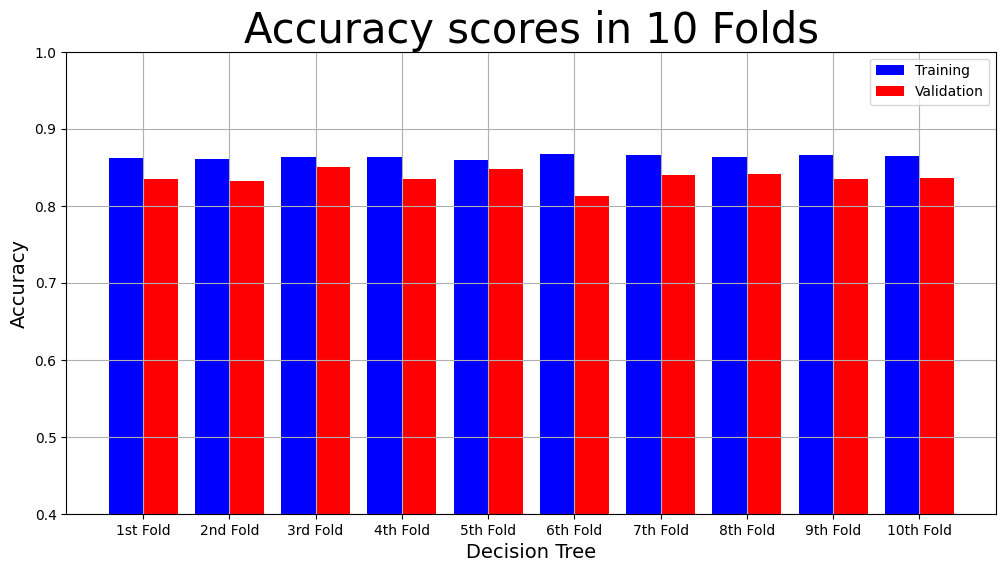

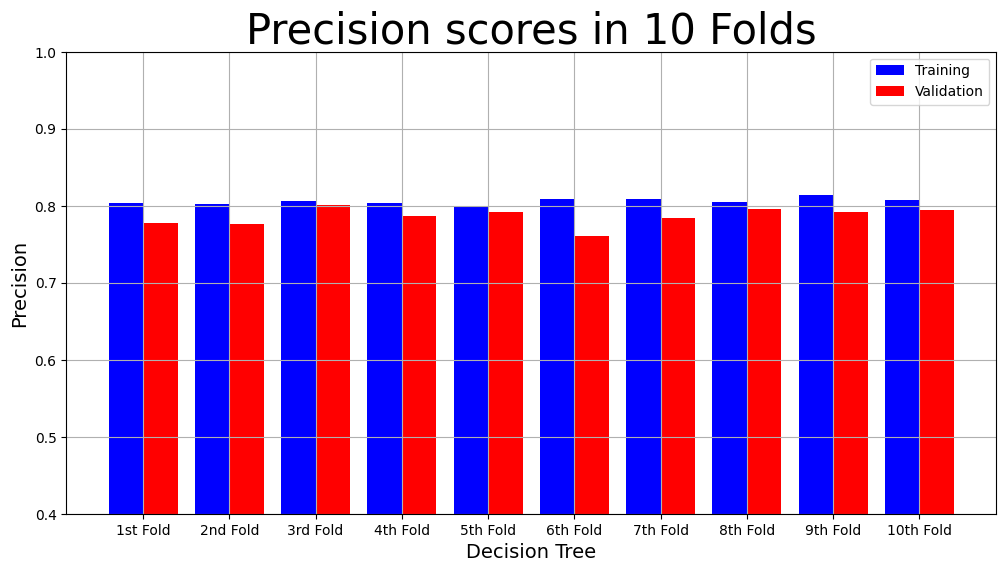

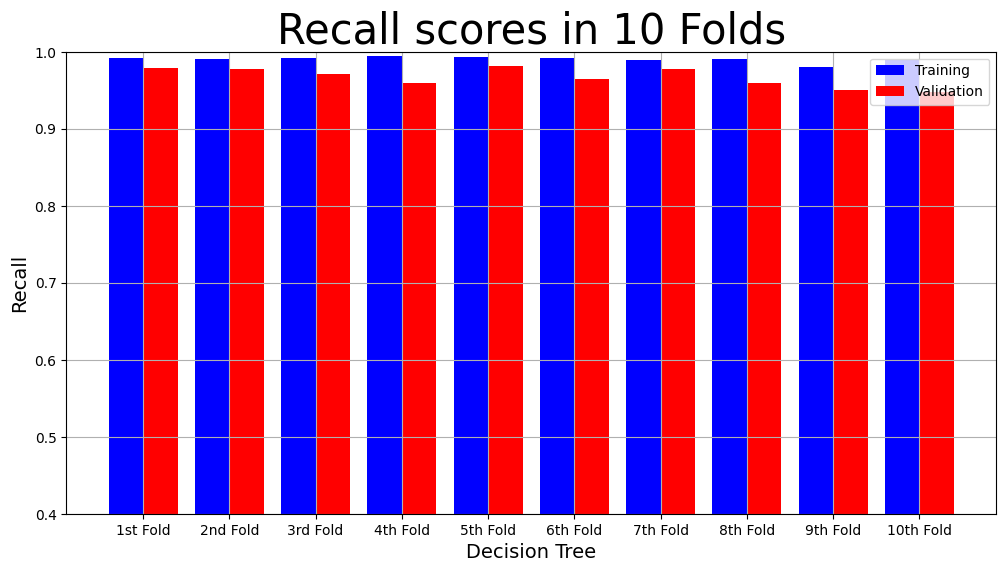

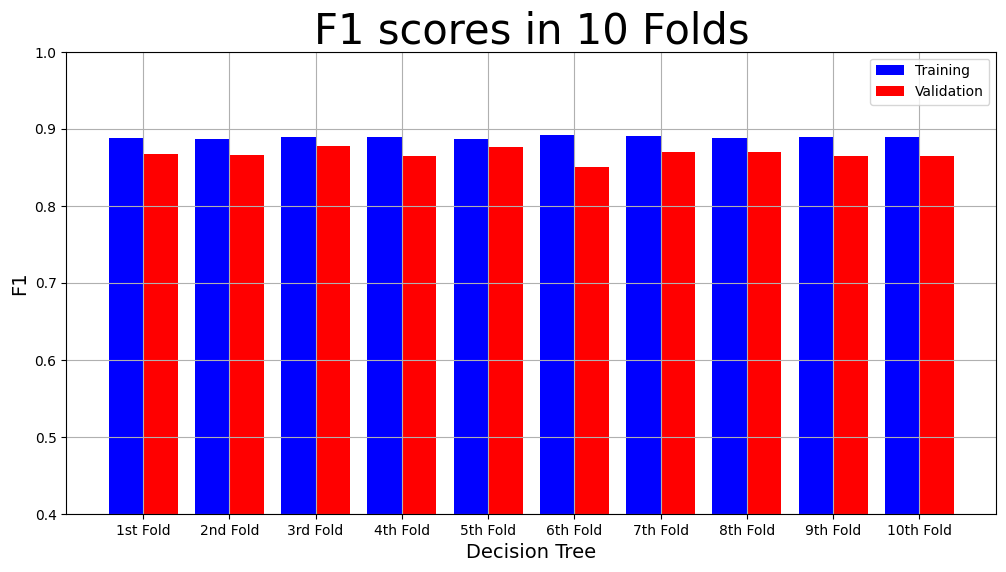

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [14]:
fold_classify_and_plot1(df, label, cv=10, max_tree_depth=10, criterion="gini")

{'Training Accuracy scores': array([0.85957191, 0.85997199, 0.85977195, 0.86037207, 0.86017203,
       0.86257251, 0.86407281, 0.86227245, 0.85787157, 0.86028603]), 'Mean Training Accuracy': 86.06935358468833, 'Training Precision scores': array([0.79831199, 0.79886397, 0.79819715, 0.80152672, 0.80040972,
       0.80367647, 0.80360281, 0.80255057, 0.79697499, 0.80375629]), 'Mean Training Precision': 0.8007870666877517, 'Training Recall scores': array([0.99672965, 0.99654797, 0.9974564 , 0.99200581, 0.99382267,
       0.99291424, 0.99673025, 0.99455041, 0.99545867, 0.98728429]), 'Mean Training Recall': 0.9943500359081595, 'Training F1 scores': array([0.88655462, 0.88682296, 0.88677112, 0.88665151, 0.88669152,
       0.888329  , 0.88980783, 0.88829399, 0.88522736, 0.88611723]), 'Mean Training F1 Score': 0.887126714207848, 'Validation Accuracy scores': array([0.83348335, 0.83258326, 0.84968497, 0.84338434, 0.84158416,
       0.80918092, 0.83258326, 0.83348335, 0.84248425, 0.84414414]), 'Me

The following features were dropped:
['mode_inactive_period_length_in_seconds']


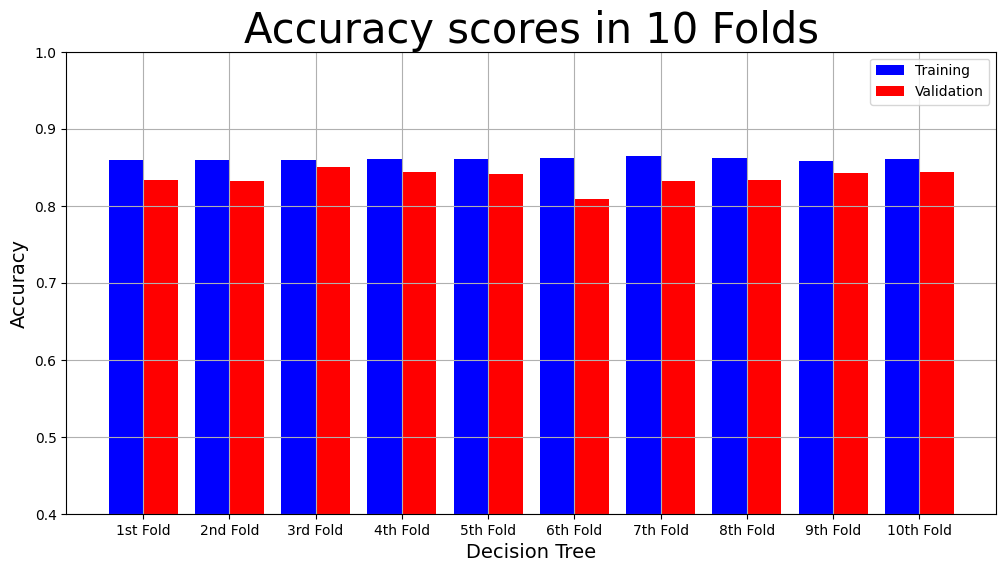

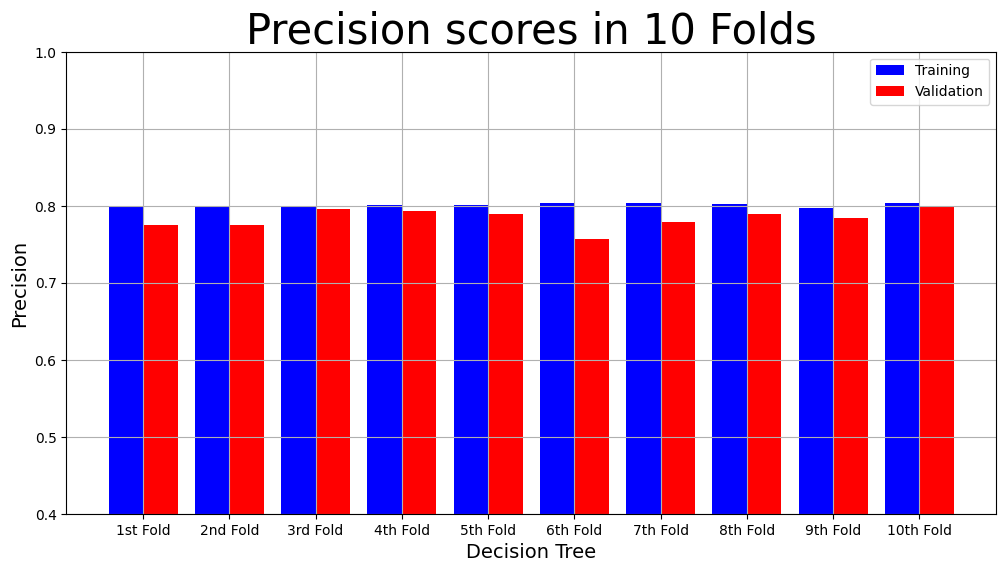

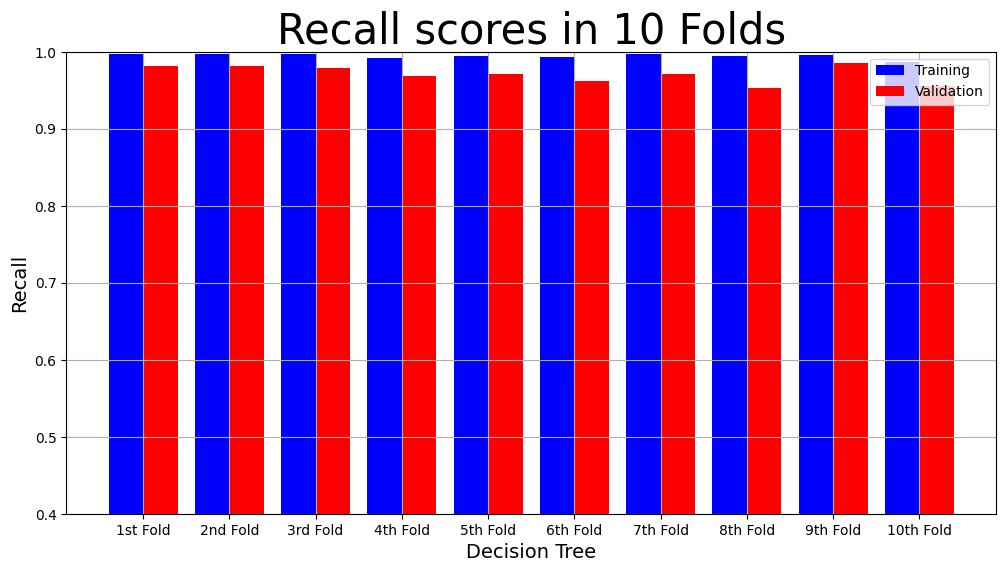

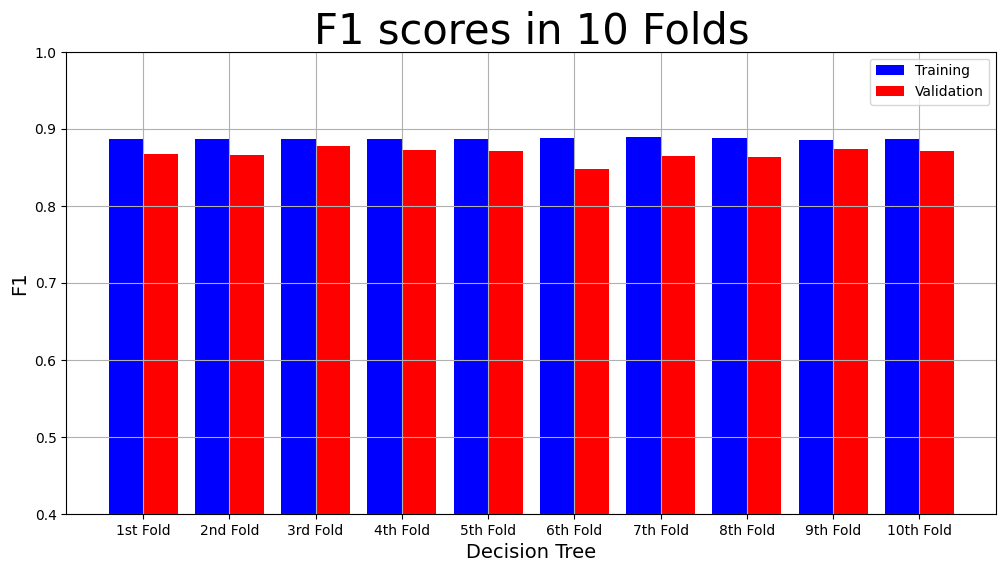

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [15]:
fold_classify_and_plot1(df, label, cv=10, max_tree_depth=10, criterion="entropy")

{'Training Accuracy scores': array([0.85957191, 0.85977195, 0.85977195, 0.86027205, 0.85927185,
       0.86267253, 0.86407281, 0.86247249, 0.85787157, 0.86028603]), 'Mean Training Accuracy': 86.06035178432826, 'Training Precision scores': array([0.79831199, 0.79871832, 0.79819715, 0.80140907, 0.7995321 ,
       0.80370534, 0.80378077, 0.80243117, 0.79697499, 0.80375629]), 'Mean Training Precision': 0.8006817176975355, 'Training Recall scores': array([0.99672965, 0.99636628, 0.9974564 , 0.99200581, 0.9934593 ,
       0.99309593, 0.99636694, 0.99527702, 0.99545867, 0.98728429]), 'Mean Training Recall': 0.9943500293073949, 'Training F1 scores': array([0.88655462, 0.88666128, 0.88677112, 0.88657952, 0.88600826,
       0.88841934, 0.88977208, 0.8885105 , 0.88522736, 0.88611723]), 'Mean Training F1 Score': 0.8870621320210585, 'Validation Accuracy scores': array([0.83348335, 0.83078308, 0.85238524, 0.84248425, 0.84158416,
       0.80828083, 0.83438344, 0.83618362, 0.83978398, 0.84594595]), 'M

The following features were dropped:
['total_likes', 'mode_inactive_period_length_in_seconds']


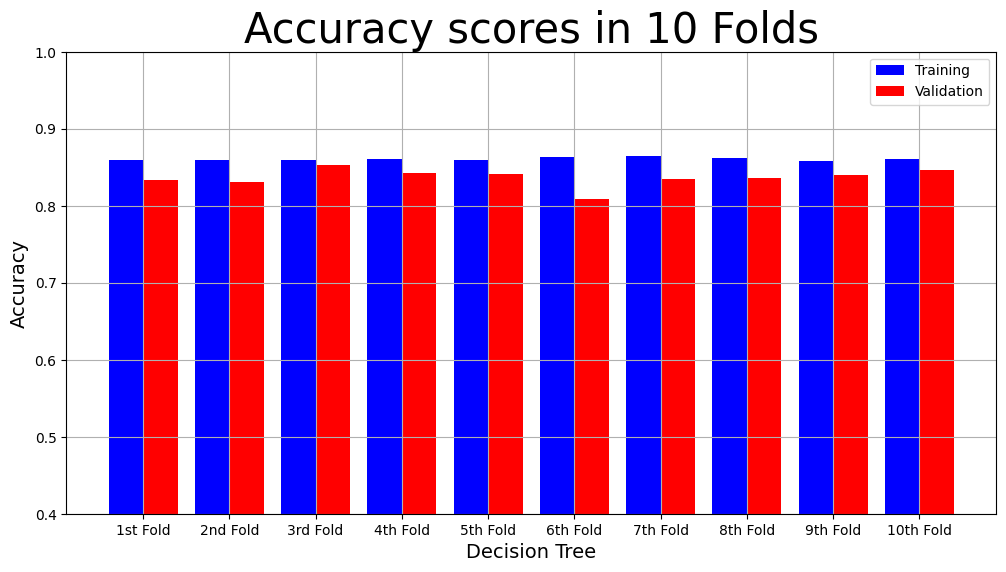

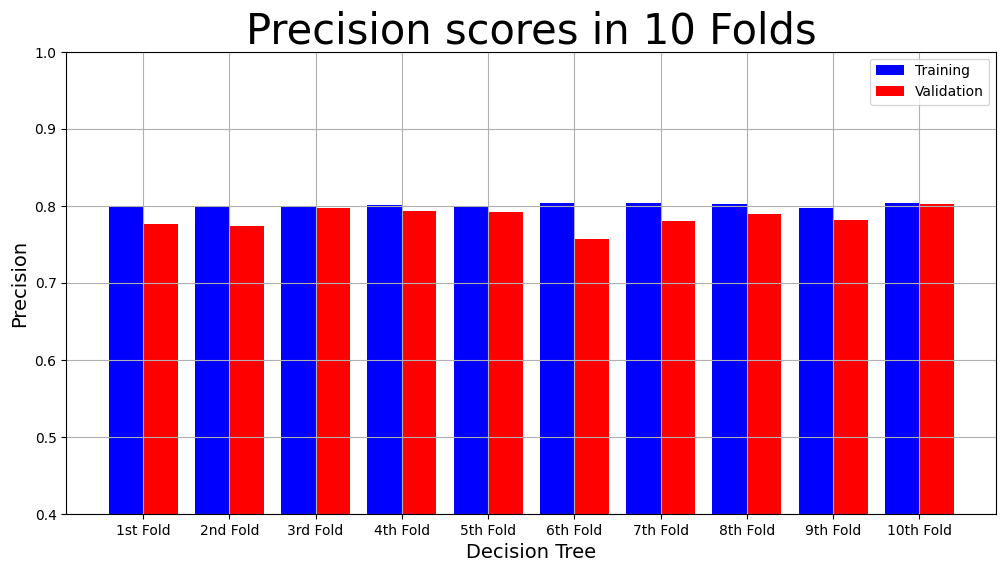

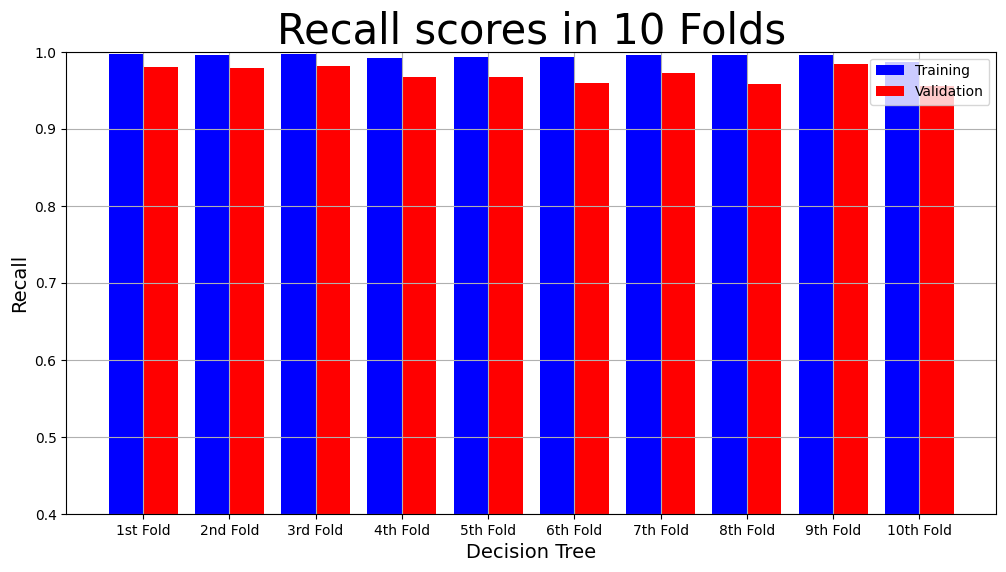

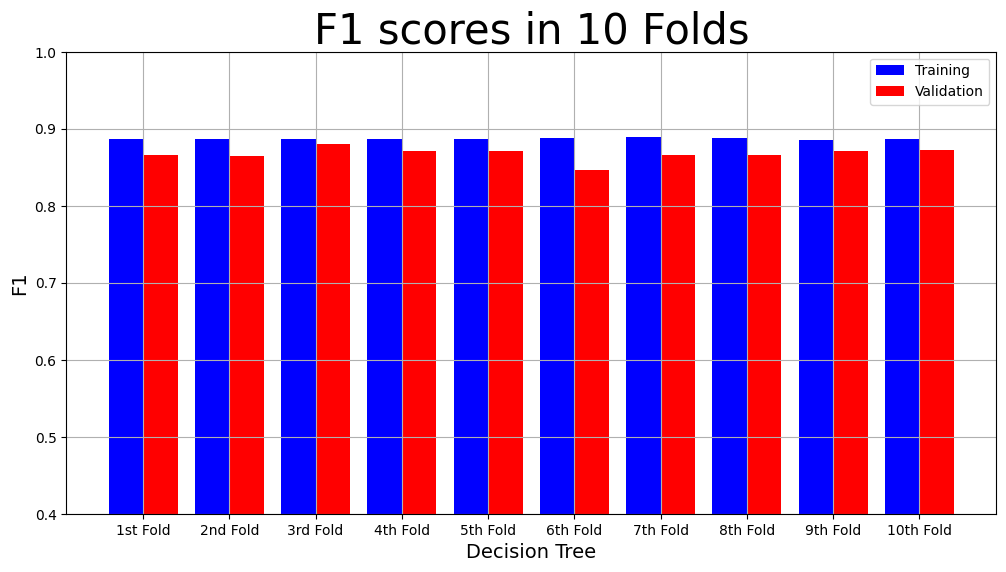

In [16]:
fold_classify_and_plot2(df, label, cv=10, max_tree_depth= 10, criterion="entropy") # no fit

{'Training Accuracy scores': array([0.84426885, 0.84186837, 0.84286857, 0.84346869, 0.84216843,
       0.84606921, 0.84706941, 0.84416883, 0.84606921, 0.84468447]), 'Mean Training Accuracy': 84.4270407236763, 'Training Precision scores': array([0.78856558, 0.78497748, 0.78678722, 0.78950463, 0.78457524,
       0.79090242, 0.79141014, 0.78755646, 0.79059203, 0.78804665]), 'Mean Training Precision': 0.7882917857094177, 'Training Recall scores': array([0.97983285, 0.98164971, 0.98019622, 0.97583576, 0.98328488,
       0.97928779, 0.98074478, 0.9818347 , 0.98001817, 0.98201635]), 'Mean Training Recall': 0.9804701196586614, 'Training F1 scores': array([0.87385563, 0.87236619, 0.87290672, 0.8728366 , 0.87276246,
       0.87507103, 0.87596333, 0.87402975, 0.87517236, 0.87440356]), 'Mean Training F1 Score': 0.8739367626021206, 'Validation Accuracy scores': array([0.82988299, 0.83078308, 0.84518452, 0.83258326, 0.84068407,
       0.80558056, 0.83618362, 0.83618362, 0.83708371, 0.85135135]), 'Me

The following features were dropped:
['total_replies', 'total_likes', 'account_discussion_creation_ratio', 'entropy_for_minute', 'entropy_for_day', 'max_number_of_tweets_in_a_day', 'avg_tweets_per_actual_day', 'mean_inactive_period_length_in_seconds', 'median_inactive_period_length_in_seconds', 'mode_count', 'statuses_count']


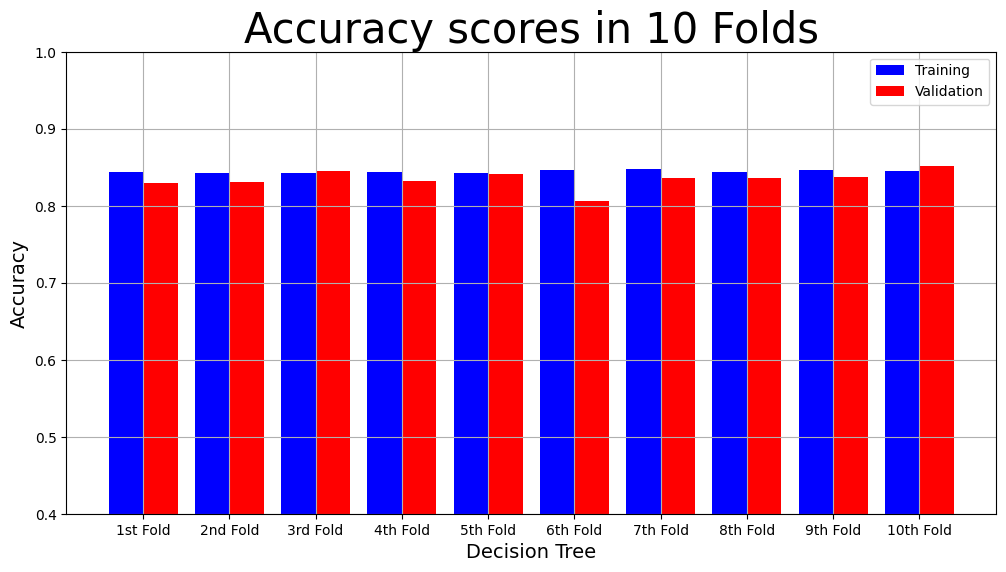

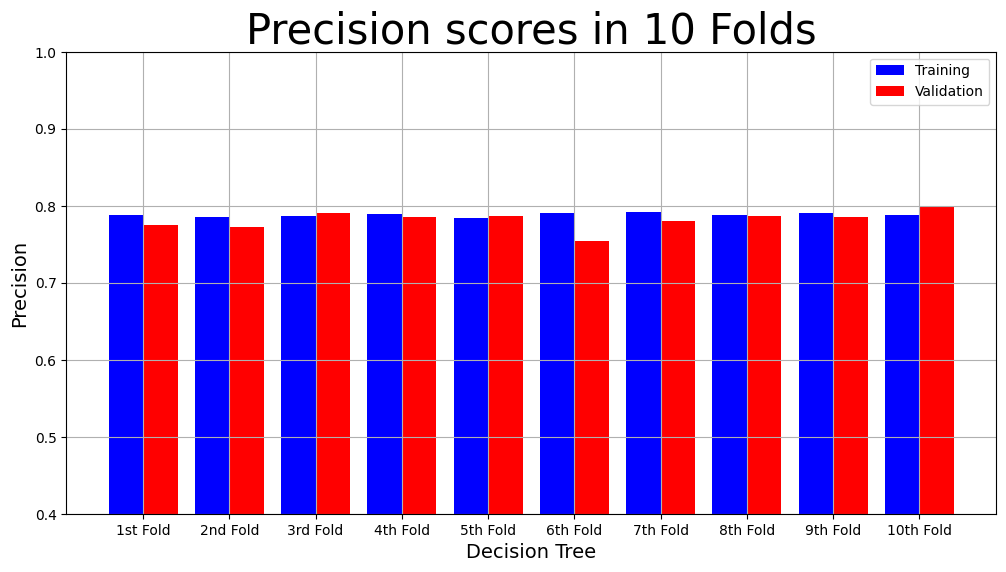

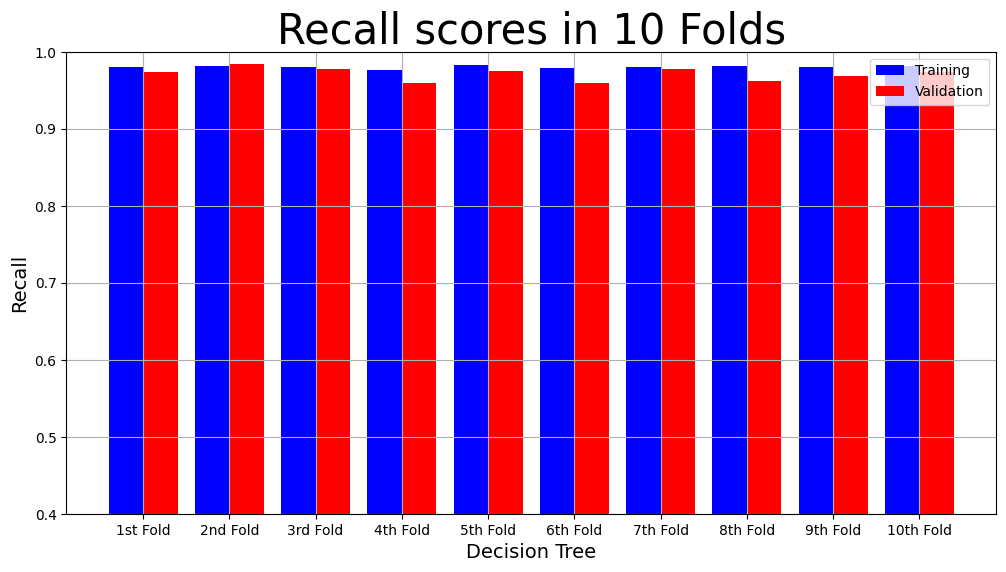

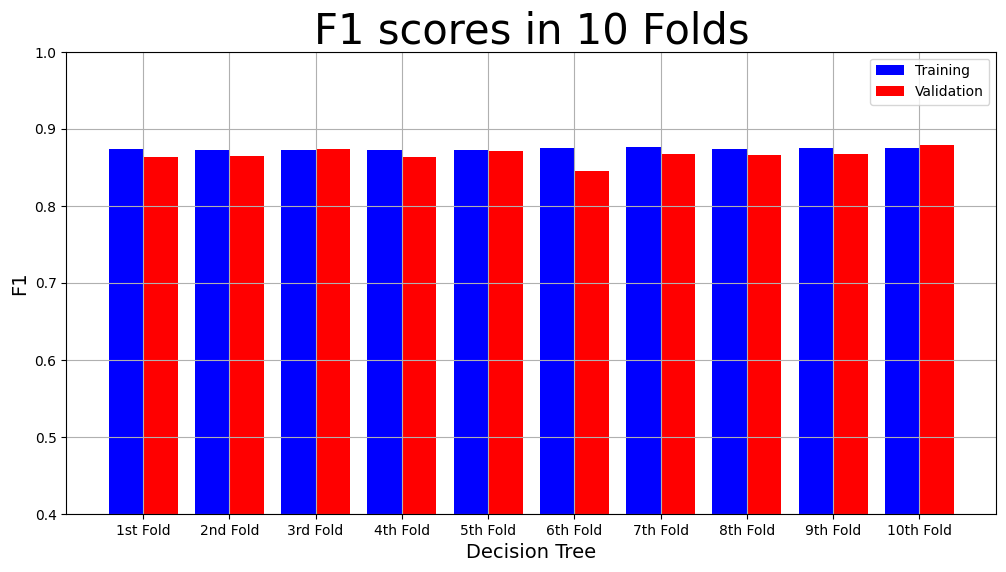

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [17]:
fold_classify_and_plot1(df, label, cv=10, max_tree_depth= 5, criterion='gini')

{'Training Accuracy scores': array([0.84196839, 0.84196839, 0.84156831, 0.84046809, 0.84086817,
       0.84546909, 0.84236847, 0.84166833, 0.84006801, 0.83978398]), 'Mean Training Accuracy': 84.16199261454452, 'Training Precision scores': array([0.78650701, 0.78567268, 0.78554779, 0.78371317, 0.78293565,
       0.78995166, 0.78384626, 0.78478071, 0.78173687, 0.78237592]), 'Mean Training Precision': 0.784706772978792, 'Training Recall scores': array([0.97856105, 0.98037791, 0.97965116, 0.98092297, 0.98364826,
       0.97983285, 0.98546776, 0.98165304, 0.98437784, 0.982198  ]), 'Mean Training Recall': 0.9816690825465223, 'Training F1 scores': array([0.87208549, 0.87229227, 0.87192755, 0.87129831, 0.87188985,
       0.87470603, 0.87316916, 0.87224598, 0.87143202, 0.87097294]), 'Mean Training F1 Score': 0.8722019607251257, 'Validation Accuracy scores': array([0.83078308, 0.83348335, 0.85058506, 0.84068407, 0.84068407,
       0.81008101, 0.83888389, 0.83528353, 0.83978398, 0.84774775]), 'Me

The following features were dropped:
['mean_inactive_period_length_in_seconds', 'median_inactive_period_length_in_seconds', 'mode_inactive_period_length_in_seconds', 'account_discussion_creation_ratio', 'statuses_count', 'avt_reply_count', 'total_replies', 'total_likes', 'avg_special_char_in_text', 'avg_mentions', 'entropy_for_minute', 'entropy_for_day', 'max_number_of_tweets_in_a_day', 'avg_tweets_per_actual_day', 'avt_favorite_count']


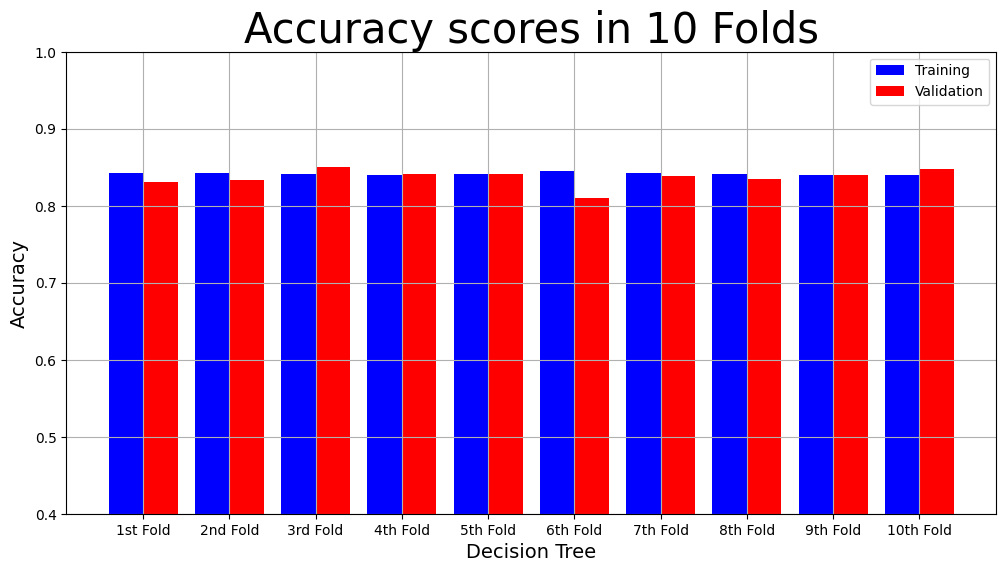

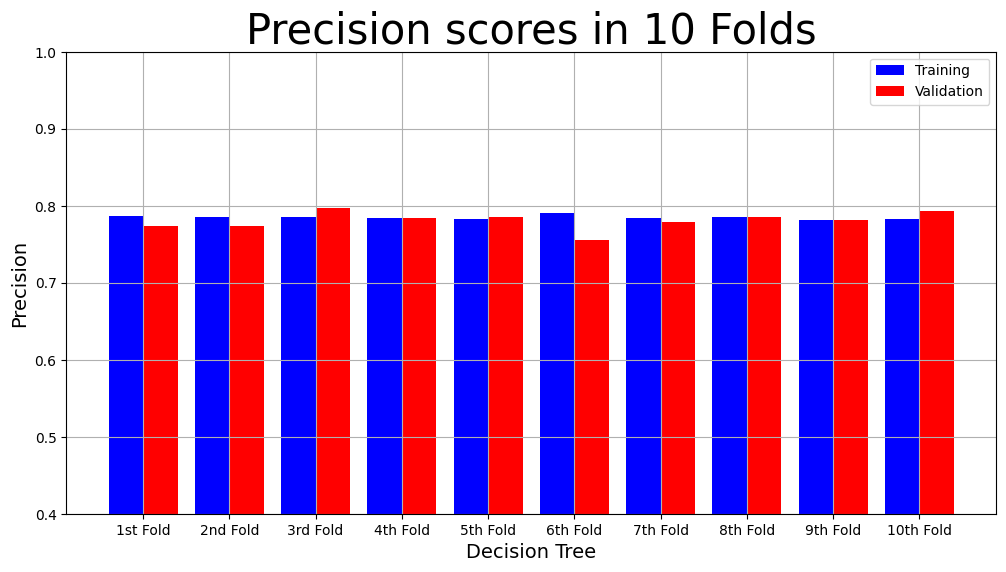

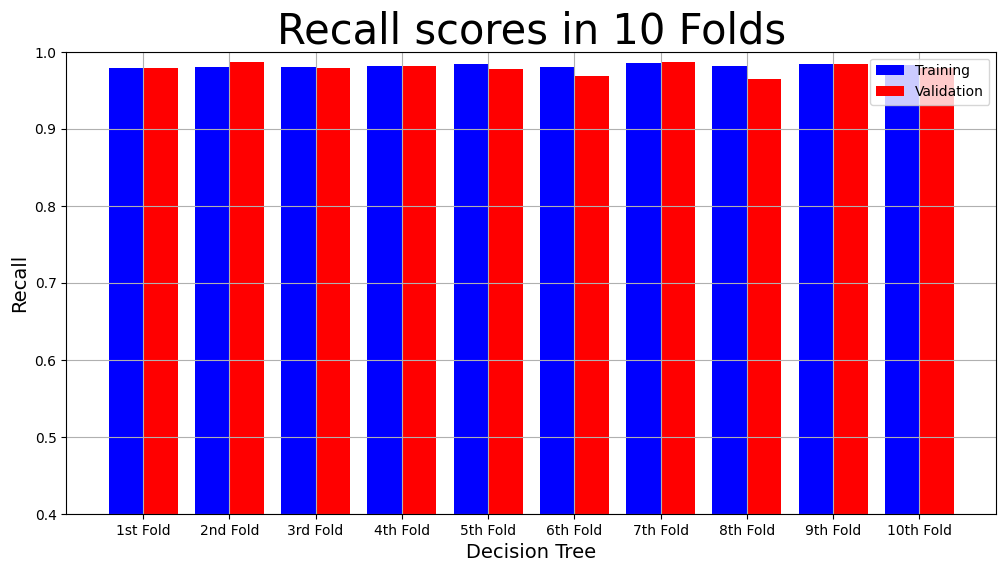

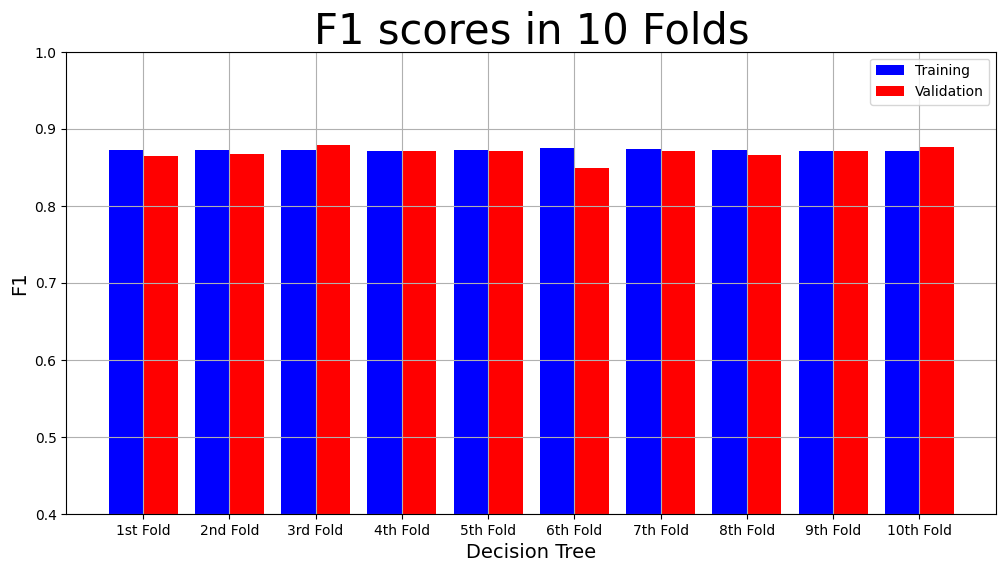

In [18]:
fold_classify_and_plot2(df, label, cv=10, max_tree_depth= 5, criterion='entropy')